# Building Decision Trees and Random Forests from scratch

Decision trees are a fundamental algorithm in machine learning. Random forests are a method of improving the performance of decision trees by training an _ensemble_ of them, i.e. training multiple decision trees and aggregating their results.

Our decision trees and random forests will be trained on the BMI dataset from [here](https://www.kaggle.com/datasets/yersever/500-person-gender-height-weight-bodymassindex) which I've downloaded and renamed to `bmi-data.csv`. We'll open it in pandas:


In [1]:
import pandas as pd

data = pd.read_csv("bmi-data.csv")

data

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3
...,...,...,...,...
495,Female,150,153,5
496,Female,184,121,4
497,Female,141,136,5
498,Male,150,95,5


Our dataset has genders, heights, weights and BMIs for 500 people. We'll use the gender, height and weight to predict the BMI. To make things slightly easier, instead of predicting BMI directly, we'll predict if the BMI is obese or not, which is when the Index column is >= 4.


In [2]:
data["Obese"] = (data["Index"] >= 4).astype("int")
data = data.drop("Index", axis=1)

data

,Gender,Height,Weight,Obese
0,Male,174,96,1
1,Male,189,87,0
2,Female,185,110,1
3,Female,195,104,0
4,Male,149,61,0
...,...,...,...,...
495,Female,150,153,1
496,Female,184,121,1
497,Female,141,136,1
498,Male,150,95,1


How do we predict if someone is obese using a decision tree? A decision tree consists of a series of binary rules (they either have a yes/no outcome), e.g. if weight >= 100 kg, then the tree predicts the person is obese. The key concept is that the tree is made of multiple stacked rules, and each rule is used to _split_ the data. At each split, some data is routed in one direction and some another. The data is continuously split until it reaches the point where it cannot be split anymore, which is where our decision tree makes a prediction. Each split in the tree is called a _node_, and the final nodes (where no more splits are made) are called _leaf nodes_.

The decision tree starts with no nodes, these are learned when the decision tree is trained (or fit) on the training data. Once the tree is trained, we can use it to make predictions on new data. The algorithm for training a decision tree uses a _cost function_ to determine how to perform a split at each node. The cost function uses _impurity_, which measures how likely the target value is to be incorrectly classified. The two most common cost functions are the Gini index and entropy, here we'll just focus on entropy.

Let's compare at what happens if we make a single split in the data when we predict obesity at weight >= 100 kg and obesity at weight >= 80 kg. We can count the number of mistakes made both splits:


In [3]:
df_100kg = data[(data["Weight"] >= 100) & (data["Obese"] == 0)]
df_80kg = data[(data["Weight"] >= 80) & (data["Obese"] == 0)]

len(df_100kg), len(df_80kg)

(18, 63)

We can see that splitting at 100 kg made 18 mistakes, and splitting at 80 kg made 63 mistakes. Therefore the split at 100 kg is less impure and thus is a better split. Cost functions are used to find splits that minimize impurity.

Entropy can be used as a measurement of impurity and is given by: $$H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)$$ where $p(x_i)$ is the probability of class $x_i$ occurring. The entropy is 0 when all the data is of the same class (minimum impurity), and is 1 when the data is evenly split between classes (maximum impurity).


In [4]:
import numpy as np


def entropy(x):
    assert isinstance(x, pd.Series)
    p = x.value_counts() / len(x)
    # 1e-10 is used to stop np.log2 throwing a division by zero error
    entropy = -np.sum(p * np.log2(p + 1e-10))
    return entropy

We can now calculate the impurity for both of the splits, where we should see that the split at 100 kg has a lower impurity than the split at 80 kg (i.e. it makes less mistakes, is less impure, and is a better split).


In [5]:
entropy((data["Weight"] >= 100) & (data["Obese"] == 0))

0.22364166419594184

In [6]:
entropy((data["Weight"] >= 80) & (data["Obese"] == 0))

0.5463652176690357

We know how to calculate impurity to tell us if a split is good or not, but what we'd like to do is calculate how much improvement in purity a split gives us compared to the data before the split. For this we use _information gain_. Information gain quantifies how much impurity in the data is reduced after a split. It is calculated as the difference in impurity before and after the split and uses entropy to measure this.


In [7]:
def get_information_gain(series, mask):
    n_true_split = sum(mask)
    n_false_split = len(mask) - n_true_split
    if n_true_split == 0 or n_false_split == 0:
        return 0
    original_impurity = entropy(series)
    true_split_impurity = entropy(series[mask])
    false_split_impurity = entropy(series[~mask])
    weighted_average_impurity = (
        n_true_split / len(mask) * true_split_impurity
        + n_false_split / len(mask) * false_split_impurity
    )
    information_gain = original_impurity - weighted_average_impurity
    return information_gain

We calculate the impurity of the data before the split, `original_impurity`, the impurities of the subsets of data created after the split, `true_split_impurity` and `false_split_impurity`, and then the combined impurity after the split taking into account the proportion of data in each subset to get the entropy after the split as `weighted_average_impurity`. The information gain is then the difference between the original entropy and the weighted average entropy after the split.

We can see that just as splitting at >= 100 kg gave us a lower impurity, it also gave us a higher information gain.


In [8]:
get_information_gain(data["Obese"], data["Weight"] >= 100)

0.35468741526665915

In [9]:
get_information_gain(data["Obese"], data["Weight"] >= 80)

0.3062635617880082

Now we know how to measure how good a split is, we can use this to build a decision tree. The steps we need to take on each node are:

1. Calculate the information gain for all variables
2. Choose the split that generates the highest information gain
3. Repeat until we hit some stopping criteria

When splitting numeric variables, e.g. weight, we get all values that variables takes within the current split, and for each value calculate the information gain when filtering all values _less_ than that value, then see which gives the highest information gain.

When splitting categorical variables, e.g. gender, we get all combinations of values that variables takes within the current split and calculate the information gain for each combination. Note: if you have a significant number of categorical variables within a column the number of combinations explodes, so libraries that implement decision trees/random forests usually have a better way of handling this.

We'll implement a function to get all potential combinations for a categorical variable:


In [10]:
import itertools


def get_categorical_options(series):
    assert isinstance(series, pd.Series)
    series = set(series)
    options = []
    for i, _ in enumerate(series):
        subset = itertools.combinations(series, i + 1)
        options.extend(subset)
    return options

In [11]:
get_categorical_options(pd.Series(["Red", "Red", "Blue", "Blue", "Green"]))

[('Green',),
 ('Red',),
 ('Blue',),
 ('Green', 'Red'),
 ('Green', 'Blue'),
 ('Red', 'Blue'),
 ('Green', 'Red', 'Blue')]

Putting all this together, we can now define a function which, when given a feature column of a DataFrame and the label column, will calculate the information gain for all possible splits of that feature and return the best split.


In [12]:
def get_max_information_gain(x_series, y_series):
    is_numeric = x_series.dtype != "object"
    if is_numeric:
        # Skip the first value as it is the minimum and if we split on it one of the splits will be empty.
        split_values = x_series.sort_values().unique()[1:].tolist()
    else:
        split_values = get_categorical_options(x_series)
    results = []
    if not split_values:
        # Handle the case when all values are the same, e.g. all one value.
        return {"split_value": None, "information_gain": 0, "is_numeric": is_numeric}
    for split_value in split_values:
        mask = x_series < split_value if is_numeric else x_series.isin(split_value)
        split_information_gain = get_information_gain(y_series, mask)
        results.append(
            {
                "value": split_value,
                "information_gain": split_information_gain,
            }
        )
    results = sorted(results, key=lambda x: x["information_gain"], reverse=True)
    best_split_value = results[0]["value"]
    best_information_gain = results[0]["information_gain"]
    return {
        "split_value": best_split_value,
        "information_gain": best_information_gain,
        "is_numeric": is_numeric,
    }

We can use this to get the best split for a given feature:


In [13]:
get_max_information_gain(data["Height"], data["Obese"])

{'split_value': 174,
 'information_gain': 0.06474831770089884,
 'is_numeric': True}

To verify, we can plot the information gain for each split value:


Text(0, 0.5, 'Information Gain')

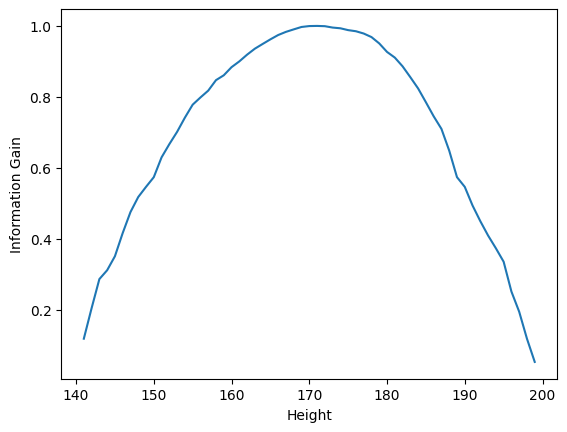

In [14]:
import matplotlib.pyplot as plt

values = data["Height"].sort_values().unique()[1:]
information_gains = [
    get_information_gain(data["Height"], data["Height"] < value) for value in values
]

fig, ax = plt.subplots()
ax.plot(values, information_gains)
ax.set_xlabel("Height")
ax.set_ylabel("Information Gain")

Now we can calculate the highest information gain for each feature, we'll write a function to iterate across all feature columns, calculate the best split for each, and then return the best split overall:


In [15]:
def get_best_split(df, y):
    column_max_information_gains = [
        {"column_name": column, **get_max_information_gain(df[column], df[y])}
        for column in df.columns
        if column != y  # We don't want to split on the target variable
    ]
    best_split_info = sorted(
        column_max_information_gains, key=lambda x: x["information_gain"]
    )[-1]
    return best_split_info

We can use this to find out that the best split for the initial data is splitting at weight >= 103 kg.


In [16]:
split_info = get_best_split(data, "Obese")

split_info

{'column_name': 'Weight',
 'split_value': 103,
 'information_gain': 0.3824541370911896,
 'is_numeric': True}

The last of the helper functions is to use the information about the best split to actually split the data:


In [17]:
def make_split(df, split_info):
    column_name = split_info["column_name"]
    split_value = split_info["split_value"]
    is_numeric = split_info["is_numeric"]
    assert is_numeric == (df[column_name].dtype != "object")
    if is_numeric:
        mask = df[column_name] < split_value
    else:
        mask = df[column_name].isin(split_value)
    df_left = df[mask]
    df_right = df[~mask]
    return df_left, df_right

Splitting at weight >= 103 kg gives us two subsets of data. We can see that there are 229 and 271 examples in each split. With 229 in the _left_ split, where weight < 103 kg, and 271 in the _right_ split, where weight >= 103 kg.


In [18]:
left, right = make_split(data, split_info)

len(data), len(left), len(right)

(500, 229, 271)

We can split each each of these subsets, and then split the resulting subsets, and so on, until we reach some stopping criteria, which is how we build our decision tree.


In [19]:
split_info = get_best_split(left, "Obese")

split_info

{'column_name': 'Height',
 'split_value': 178,
 'information_gain': 0.28026630900174687,
 'is_numeric': True}

In [20]:
split_info = get_best_split(right, "Obese")

split_info

{'column_name': 'Weight',
 'split_value': 116,
 'information_gain': 0.09289094500737183,
 'is_numeric': True}

We define a `DecisionNode` class which will represent the nodes in our decision tree. Each node contains information about the split (the column, value, if it was numeric), the left and right children nodes, if the tree is classification or regression, and the predicted label (only when the node is a leaf node).


In [21]:
class DecisionNode:
    def __init__(
        self,
        column,
        split_value,
        is_numeric,
        left,
        right,
        is_classification,
        prediction,
    ):
        self.column = column
        self.split_value = split_value
        self.is_numeric = is_numeric
        self.left = left
        self.right = right
        self.is_classification = is_classification
        self.prediction = prediction

    def __repr__(self, depth=0, indent="    "):
        # Print the tree structure
        prefix = depth * indent
        if self.is_leaf():
            return f"{prefix}Leaf(prediction={self.prediction})"
        description = f"{prefix}DecisionNode(column={self.column}, split_value={self.split_value}, is_numeric={self.is_numeric})\n"
        if self.left:
            description += f"{prefix}left:\n{self.left.__repr__(depth + 1, indent)}\n"
        if self.right:
            description += f"{prefix}right:\n{self.right.__repr__(depth + 1, indent)}"
        return description

    def is_leaf(self):
        # If a node has no left and right children, it is a leaf node
        return self.left is None and self.right is None

Finally, we want to build our tree, which we do by recursively splitting the data until we reach some stopping criteria. When we reach a stopping criteria, we create a leaf node that makes a prediction. If it's a classification problem, we predict the most common class in the subset of data, and if it's a regression problem, we predict the mean of the subset of data. Our `build_tree` function is wrapped in a `train_decision_tree` function which builds the tree from a depth of zero and returns the tree itself.

The stopping criteria we'll use are:

-   Maximum depth: the maximum number of splits we want to make
-   Minimum samples: the minimum number of samples we want to have in a node before we stop splitting
-   Minimum information gain: the minimum information gain we want to have before we stop splitting


In [22]:
def build_tree(
    df, y, depth, max_depth, min_samples_split, min_information_gain, is_classification
):
    # Check if we have reached the maximum depth
    if depth >= max_depth:
        return create_leaf_node(df, y, is_classification)

    # Check if we have reached the minimum number of samples required to split
    if len(df) < min_samples_split:
        return create_leaf_node(df, y, is_classification)

    # Get the best split
    split_info = get_best_split(df, y)

    # Check if the best split has enough information gain
    if split_info["information_gain"] < min_information_gain:
        return create_leaf_node(df, y, is_classification)

    # Make the split
    df_left, df_right = make_split(df, split_info)

    # Build the left and right subtrees
    subtree_left = build_tree(
        df_left,
        y,
        depth + 1,
        max_depth,
        min_samples_split,
        min_information_gain,
        is_classification,
    )

    subtree_right = build_tree(
        df_right,
        y,
        depth + 1,
        max_depth,
        min_samples_split,
        min_information_gain,
        is_classification,
    )

    # Make the decision node
    return DecisionNode(
        column=split_info["column_name"],
        split_value=split_info["split_value"],
        is_numeric=split_info["is_numeric"],
        left=subtree_left,
        right=subtree_right,
        is_classification=is_classification,
        prediction=None,
    )


def create_leaf_node(df, y, is_classification):
    # If it is a classification problem, we return the mode of the target variable
    if is_classification:
        prediction = df[y].mode()[0]
    # If it is a regression problem, we return the mean of the target variable
    else:
        prediction = df[y].mean()

    return DecisionNode(
        column=None,
        split_value=None,
        is_numeric=None,
        left=None,
        right=None,
        is_classification=is_classification,
        prediction=prediction,
    )


def train_decision_tree(
    df,
    y,
    max_depth,
    min_samples_split,
    min_information_gain,
    is_classification,
):
    return build_tree(
        df, y, 0, max_depth, min_samples_split, min_information_gain, is_classification
    )

Now, we can specify which column is our label column, the values of our stopping criteria, and if our tree is doing classification or regression, then train our tree.

Note: Ideally we should use be using a train/validation/test splits of our data, but for simplicity here we'll just train on the entire dataset.


In [23]:
y = "Obese"
max_depth = 10
min_samples_split = 2
min_information_gain = 0.1
is_classification = True

tree = train_decision_tree(
    data,
    y,
    max_depth,
    min_samples_split,
    min_information_gain,
    is_classification,
)

We can also see the individual splits in our tree. We can see that the first split was at weight >= 103 kg, the left split from that (where weight < 103 kg) was split at height >= 178, and the right split (where weight >= 103 kg) was already a leaf node.


In [24]:
tree

DecisionNode(column=Weight, split_value=103, is_numeric=True)
left:
    DecisionNode(column=Height, split_value=178, is_numeric=True)
    left:
        DecisionNode(column=Weight, split_value=66, is_numeric=True)
        left:
            Leaf(prediction=0)
        right:
            DecisionNode(column=Height, split_value=151, is_numeric=True)
            left:
                DecisionNode(column=Weight, split_value=67, is_numeric=True)
                left:
                    DecisionNode(column=Height, split_value=149, is_numeric=True)
                    left:
                        Leaf(prediction=1)
                    right:
                        Leaf(prediction=0)
                right:
                    Leaf(prediction=1)
            right:
                DecisionNode(column=Weight, split_value=82, is_numeric=True)
                left:
                    DecisionNode(column=Height, split_value=161, is_numeric=True)
                    left:
                        Dec

We can make predictions with our tree by recursively traversing the tree with our input data until we hit a leaf node, and then returning the prediction at that leaf node.


In [25]:
def _predict_tree(tree, example):
    if tree.is_leaf():
        return tree.prediction
    if tree.is_numeric:
        if example[tree.column] < tree.split_value:
            return _predict_tree(tree.left, example)
        else:
            return _predict_tree(tree.right, example)
    else:
        if example[tree.column] in tree.split_value:
            return _predict_tree(tree.left, example)
        else:
            return _predict_tree(tree.right, example)


def predict_tree(tree, x):
    if isinstance(x, pd.Series):
        return _predict_tree(tree, x)
    else:
        assert isinstance(x, pd.DataFrame)
        return x.apply(lambda row: _predict_tree(tree, row), axis=1)

We can make a prediction for a single example:


In [26]:
example = data.iloc[0]

example

Gender    Male
Height     174
Weight      96
Obese        1
Name: 0, dtype: object

In [27]:
predict_tree(tree, example)

1

We can also make predictions for all of the examples in the DataFrame:


In [28]:
predictions = predict_tree(tree, data)

In [29]:
predictions

0      1
1      0
2      1
3      1
4      0
      ..
495    1
496    1
497    1
498    1
499    1
Length: 500, dtype: int64

We can see that our predictions are not 100% accurate, even though we trained our tree on the entire dataset. This is because our tree is overfitting the data.


In [30]:
(predictions == data["Obese"]).sum()

487

In [31]:
errors = data[data["Obese"] != predictions]

In [32]:
errors

,Gender,Height,Weight,Obese
3,Female,195,104,0
5,Male,189,104,0
36,Female,197,114,0
82,Female,190,105,0
92,Female,194,111,0
137,Male,194,108,0
146,Male,194,106,0
149,Female,168,115,0
184,Female,192,108,0
291,Male,183,105,0


Next, we'll build a random forest. A random forest is an ensemble of decision trees. We train multiple decision trees each using a _bootstrapped_ version of the original dataset. In other words, each tree is trained on a dataset which is the same size (number of examples) as the original data but the examples are sampled from the original dataset with replacement. This technique is called _bagging_ (or _bootstrap aggregating_).

After we've trained the trees (a forest) we can use them to make predictions. For classification problems, we use the most common prediction from all the trees, and for regression problems, we use the mean prediction from all the trees.


In [33]:
import tqdm


def train_random_forest(
    data,
    y,
    n_trees=10,
    max_depth=2,
    min_samples_split=2,
    min_information_gain=0.01,
    is_classification=True,
):
    trees = []
    for _ in tqdm.tqdm(range(n_trees)):
        # Bootstrap sample the data
        sample = data.sample(frac=1, replace=True)
        # Train a decision tree on the bootstrapped sample
        tree = train_decision_tree(
            sample,
            y,
            max_depth,
            min_samples_split,
            min_information_gain,
            is_classification,
        )
        trees.append(tree)
    return trees

We'll train our forest, which consists of 25 trees, using the same stopping criteria as before:


In [34]:
y = "Obese"
n_trees = 25
max_depth = 10
min_samples_split = 2
min_information_gain = 0.1
is_classification = True

forest = train_random_forest(
    data,
    y,
    n_trees,
    max_depth,
    min_samples_split,
    min_information_gain,
    is_classification,
)

100%|███████████████████████████████████████████| 25/25 [00:33<00:00,  1.32s/it]


Finally, we'll define functions the make our predictions:


In [35]:
def _predict_forest(forest, x):
    predictions = [predict_tree(tree, x) for tree in forest]
    is_classification = forest[0].is_classification
    if is_classification:
        return max(set(predictions), key=predictions.count)
    else:
        return np.mean(predictions)


def predict_forest(forest, x):
    if isinstance(x, pd.Series):
        return _predict_forest(forest, x)
    else:
        assert isinstance(x, pd.DataFrame)
        return x.apply(lambda row: _predict_forest(forest, row), axis=1)

We can predict on one sample:


In [36]:
predict_forest(forest, example)

1

And we can also predict on the entire DataFrame, and see that our predictions are more accurate than using a single decision tree (2 errors vs 13):


In [37]:
(predict_forest(forest, data) == data["Obese"]).sum()

498

As we can see, random forests are a small extension (both conceptually and in code) to decision trees, but significantly improve their performance. For using random forests in actual code, I'd recommend [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) or [xgboost](https://xgboost.readthedocs.io/en/stable/index.html)/[catboost](https://catboost.ai/en/docs/) (both of which are not actually random forests but work in a similar way -- by using an ensemble of decision trees).